<h1>CIFAR 10</h1>

<h1>Importing Modules</h1>


In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [2]:
train_batchsize = 100
test_batchsize = 10
resized_img_size = 32
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(size=(resized_img_size, resized_img_size)),
     torchvision.transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batchsize)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batchsize)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize data

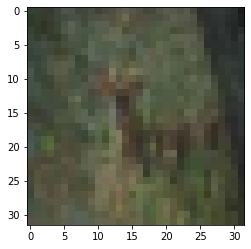

In [3]:
plt.imshow(train_data[10][0].permute(1,2,0)) 

# Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,5,(5,5),padding = "same")
        self.pool1 = nn.MaxPool2d((3,3),stride=2)
        self.conv2 = nn.Conv2d(5,7,(5,5),padding="same")
        self.pool2 = nn.MaxPool2d((3,3),stride=2)
        self.conv3 = nn.Conv2d(7,9,(5,5),padding="same")
        self.pool3 = nn.MaxPool2d((3,3),stride=2)
        self.linearlayer = nn.Linear(144,256)
        self.linearlayer2 = nn.Linear(256,10)
    def forward(self,X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = self.pool3(F.relu(self.conv3(X)))
        X = X.view(-1,81) #Flatten
        #X = F.relu(self.linearlayer(X))
        #X = self.linearlayer2(X)
        return X
model = Net()
#print(train_loader)
#print(model([train_data[0][0]]))

In [7]:
from ADAM import ADAM
trainingLoss = {}
# Fixed seed for random weight initialization (to keep the weights same for all
# the models)
#torch.manual_seed(3)
seed = 10
file = open("./results/TrainingLossess.txt","w")
def trainDifOptimizer(optmzr):
    torch.manual_seed(seed)
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = None
    if optmzr=='Adam_scratch':
      optimizer = ADAM(model.parameters(), lr=0.01) # lr=0.001 -> standard
    else:
      optimizer = getattr(torch.optim, optmzr)(model.parameters(), lr=0.01)
    
    n_epochs = 15  # suggest training between 20-50 epochs

    model.train()  # prep model for training
    trainLossForOptimizer = []
    print("Optimizer : ", optmzr, "\n")
    file.writelines(["Optimizer : ", optmzr, "\n"])
    for epoch in range(n_epochs):
        train_loss = 0.0

        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

        # print training statistics
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        trainLossForOptimizer.append(train_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1,
            train_loss
        ))
        file.write('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1,
            train_loss
        ))
    torch.save(model, 'saved_models/'+optmzr+'_cnn_model')
    trainingLoss[optmzr] = trainLossForOptimizer
    print("\n-----------------------------------------\n")
    file.write("\n-----------------------------------------\n")

optimizersLst = ['RMSprop','Adam_scratch','Adam', 'SGD','Adadelta']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)
file.write("***********************************OVER********************************")
print(trainingLoss)

Optimizer :  RMSprop 

Epoch: 1 	Training Loss: 2.595338
Epoch: 2 	Training Loss: 2.418368
Epoch: 3 	Training Loss: 2.387967
Epoch: 4 	Training Loss: 2.340788
Epoch: 5 	Training Loss: 2.313610
Epoch: 6 	Training Loss: 2.277159
Epoch: 7 	Training Loss: 2.259121
Epoch: 8 	Training Loss: 2.246493
Epoch: 9 	Training Loss: 2.237967
Epoch: 10 	Training Loss: 2.230173
Epoch: 11 	Training Loss: 2.227934
Epoch: 12 	Training Loss: 2.223791
Epoch: 13 	Training Loss: 2.222126
Epoch: 14 	Training Loss: 2.218177
Epoch: 15 	Training Loss: 2.215188

-----------------------------------------

Optimizer :  Adam_scratch 

Epoch: 1 	Training Loss: 2.391550
Epoch: 2 	Training Loss: 2.277755
Epoch: 3 	Training Loss: 2.256017
Epoch: 4 	Training Loss: 2.238493
Epoch: 5 	Training Loss: 2.219092
Epoch: 6 	Training Loss: 2.179754
Epoch: 7 	Training Loss: 2.114354
Epoch: 8 	Training Loss: 2.089770
Epoch: 9 	Training Loss: 2.074109
Epoch: 10 	Training Loss: 2.061531
Epoch: 11 	Training Loss: 2.051253
Epoch: 12 	Tr

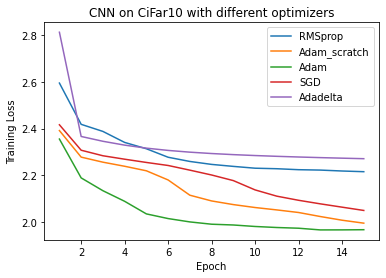

In [8]:
Xval = np.arange(1, 16,1)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("CNN on CiFar10 with different optimizers")  # add title
for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()